In [1]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.backends.mps
import time
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.pylab as pylab
import matplotlib.cm as cm
from torch.autograd.anomaly_mode import set_detect_anomaly

params = {'font.size' : 16 }
pylab.rcParams.update(params)

In [2]:
#Hyperparameters

padding_size = 2
filter_size = 3
step_size = 1
num_features = 2
num_connected_layers = 10
num_conv_layers = 3
num_classifications = 10
num_neurons_per_layer = 50
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
    torch.dtype=torch.float32
else:
    device = "cpu"

torch.autograd.anomaly_mode.set_detect_anomaly(False)

In [3]:
train_data = pd.read_csv("/Users/adityatandon/Documents/VS Code/Learn ML/Data/MNIST/mnist_train.csv")
test_data = pd.read_csv("/Users/adityatandon/Documents/VS Code/Learn ML/Data/MNIST/mnist_test.csv")
test_img = torch.tensor(train_data.iloc[0].to_list()[1:], dtype=torch.float32, device=device).view(28, 28)

In [ ]:
plt.imshow(test_img.to("cpu"), cmap='gray')

In [ ]:
# Conv Layer using normal for loops
class Conv_layer2():
    def __init__(self, filter_size:int, num_features: int, device=device):
        self.device = device
        self.num_features = num_features
        self.kernel = torch.randn(num_features, filter_size, filter_size, dtype=torch.float32, device=self.device)
        # self.kernel = torch.tensor([[[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], [[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]], dtype=torch.float32, device=device)
        # # print(padded_image.shape, self.kernel.shape)
        self.bias = torch.randn(filter_size, filter_size, dtype=torch.float32, device=self.device)
        print(self.kernel)

    def convolve(self, image: torch.tensor):
        # self.kernel = torch.flip(self.kernel, dims=(0,))
        start_time = time.time()
        if(image.dim() <= 2):
            unsqueezed_img = image.unsqueeze(dim=0)
        else:
            unsqueezed_img = image
        padded_image = nn.functional.pad(unsqueezed_img, (filter_size - 1, filter_size - 1, filter_size - 1, filter_size - 1, 0, 0))
        # print(padded_image.shape, padded_image[0, :10, :10])
        conv_img = torch.zeros(size=(num_features*unsqueezed_img.shape[0], unsqueezed_img.shape[1], unsqueezed_img.shape[2]), device=self.device)
        for feat in range(num_features):
            for k in range(padded_image.shape[0]):
                for i in range(padded_image.shape[1] - self.kernel[feat].shape[0]):
                    for j in range(padded_image.shape[2] - self.kernel[feat].shape[1]):
                        pixels = padded_image[k, i:i + self.kernel[feat].shape[0], j:j + self.kernel[feat].shape[1]]
                        conv = pixels * self.kernel[feat]
                        conv += self.bias
                        conv_img[feat, i:i + self.kernel[feat].shape[0] - step_size, j:j + self.kernel[feat].shape[1] - step_size] += torch.sum(conv)
                        # conv_img[feat, i:i + 1, j:j + 1] += torch.sum(conv)
        
        end_time = time.time()
        print(end_time - start_time)
        return conv_img, self.kernel
    
    def pool(self, step_size: int, conv_img: torch.tensor):
        pool_kern = torch.ones(step_size, step_size, device=self.device)
        pool_size = [conv_img.shape[-3], int((conv_img.shape[-2] - step_size)/step_size + 1), int((conv_img.shape[-1] - step_size)/step_size + 1)]
        pool_img = torch.zeros(pool_size, device=device)
        for feat in range(num_features):
            row = 0
            for i in range(pool_img.shape[-2]):
                col = 0
                for j in range(pool_img.shape[-1]):
                    pixels = conv_img[feat, row:row + step_size, col:col + step_size]
                    conv = pixels * pool_kern
                    pool_img[feat, i, j] = torch.max(conv)
                    col += step_size 
                    
                row += step_size 
        return pool_img
    
    def forward(self, image: torch.tensor, step_size: int):
        conv_img, kernel = self.convolve(image)
        out = conv_img.relu()
        return out
    
    # def train(self, x, )

        

In [ ]:
conv_layer = Conv_layer2(filter_size=filter_size, num_features=num_features)

In [ ]:
conv_img, kernel = conv_layer.convolve(image=test_img)

In [ ]:
conv_img.shape

In [ ]:
pool_img = conv_layer.pool(step_size=step_size, conv_img=conv_img)

In [ ]:
pool_img.shape

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(conv_img[0].to("cpu"), cmap='gray')
ax[1].imshow(pool_img[0].to("cpu"), cmap='gray')

In [ ]:
test_img = conv_img

In [ ]:
kern = torch.randn(num_features, filter_size, filter_size, requires_grad=True, dtype=torch.float32, device=device)
kern

In [17]:
# for multi dimensioanl images with a step size of 1 - 1:1 image to conved_image size; dimensions increase by 2
# convolution using a matrix multiplication
class Convolver:
    
    def __init__(self, kern, bias, x, device=device) -> None:
        
        if(x.dim() <= 2):
            self.img = x.unsqueeze(dim=1)
        else:
            self.img = x
        # print(self.img.shape)
        # self.w = torch.randn(num_features * self.img.shape[-3], filter_size, filter_size, requires_grad=True, dtype=torch.float32, device=device)
        # self.b = torch.randn(self.img.shape[-1] * self.img.shape[-2], requires_grad=True, dtype=torch.float32, device=device)
        self.w = kern
        # print(self.w.shape)
        self.b = bias
        self.device = device


    def flatten_pad(self):
        
        pad_size = int((filter_size - 1) / 2) 
        img = nn.functional.pad(self.img, (pad_size, pad_size, pad_size, pad_size))
        # print(img.shape)
        n = torch.zeros(2)
        for i in range(2):
            n[i] = ((img.shape[-i - 1] - filter_size) / step_size) + 1
        # print(n)
        # flat_img = img.flatten().clone().detach().view(img.shape[-3], img.shape[-2]*img.shape[-1]).float()
        flat_img = img.flatten().clone().view(img.shape[-4], img.shape[-3], img.shape[-2]*img.shape[-1]).float()
        # flat_kern = self.w.view(num_features * self.img.shape[-3], filter_size * filter_size)
        # print("img shape = ",self.img.shape)
        flat_kern = self.w.view(self.w.shape[-3], filter_size * filter_size)
        # print("flat kern shape = ", flat_kern.shape)
        return n, img, flat_img, flat_kern
    

    def change_kern_multi(self):

        n, img, flat_img, flat_kern = self.flatten_pad()

        new_kern = torch.zeros(self.w.shape[-3] , int(torch.prod(n)), img.shape[-2] * img.shape[-1], device=device) #produces num_feat x n x n convolution
        # print("changed kern shape = ", new_kern.shape)
        flat_kern = torch.cat([flat_kern for _ in range(1)], dim=0)
        # print("flat kern_cat shape = ", flat_kern.shape)

        for k  in range(new_kern.shape[-3]):
            start_idx = 0
            for i in range(new_kern.shape[-2]):
                j = 0
                c = 0
                if i == 0:
                    start_idx = start_idx
                elif i % int(n[0]) != 0:
                    start_idx += step_size * step_size
                else: 
                    start_idx = int((i+1-step_size)//int(n[0]) * img.shape[-2])

                while j < new_kern.shape[-1] and start_idx+j+filter_size <= new_kern.shape[-1]:
                    new_kern[k][i][start_idx + j:start_idx + j + filter_size] = flat_kern[k][c:c + filter_size]
                    c += filter_size
                    j += img.shape[-2]
                    if c == flat_kern.shape[-1]:
                        break
        return n, new_kern, flat_img
    
    def convolve(self): #convolves image using a kernel made from self.w
        start_time = time.time()
        # conved_final = torch.empty(batch_size, num_features*self.img.shape[-3], self.img.shape[-2], self.img.shape[-1]) 
        # for i in range(batch_size):
        conved_final = []
        n, changed_kern, flat_img = self.change_kern_multi()
        # print("flat img shape = ", flat_img.shape)
        to_be_cat = [flat_img for _ in range(self.img.shape[-3])]
        copy_flat_img = torch.cat(to_be_cat, dim=1).unsqueeze(dim=-2)
        # print("copy flat img shape",copy_flat_img.shape)
        # print(changed_kern.shape, "changed_kern")
        # copy_flat_img = flat_img
        # conved_final = changed_kern @ copy_flat_img[:][0].to(self.device)
        for batch in range(self.img.shape[-4]):
            # torch.stack((conved_final,(changed_kern @ copy_flat_img[batch][i]).unsqueeze(dim=-1).to(self.device)), dim=1)
            conv = [changed_kern @ torch.transpose(copy_flat_img[batch][j], -1, -2) for j in range(self.img.shape[-3])]
            conved_final.append(torch.concat(conv, dim=0).squeeze(dim=0))
        conved_final = torch.stack(conved_final)
        # print(conved_final.shape)
        
        squeezed_convd_mat = conved_final.squeeze(dim=-1)
        squeezed_convd_mat += self.b
        # print(squeezed_convd_mat.shape)
        
        conv_img = squeezed_convd_mat.reshape(batch_size, self.img.shape[-3] * num_features, int(n[-2]), int(n[-1]))

        end_time = time.time()
        # print(end_time - start_time)
        return conv_img #returns convolved image 
    
    def pool(self, step_size: int, conv_img: torch.tensor):
        pool_kern = torch.ones(step_size, step_size, device=self.device)
        pool_size = [conv_img.shape[-4], conv_img.shape[-3], int((conv_img.shape[-2] - step_size)/step_size + 1), int((conv_img.shape[-1] - step_size)/step_size + 1)]
        pool_img = torch.zeros(pool_size, device=device)
        for batch in range(conv_img.shape[-4]):
            for feat in range(num_features):
                row = 0
                for i in range(pool_img.shape[-2]):
                    col = 0
                    for j in range(pool_img.shape[-1]):
                        pixels = conv_img[batch, feat, row:row + step_size, col:col + step_size]
                        conv = pixels * pool_kern
                        pool_img[feat, i, j] = torch.max(conv)
                        col += step_size 
                    row += step_size 
        return pool_img


In [207]:
rand_bias = torch.randn(1, 28*28, requires_grad=True, dtype=torch.float32, device=device)
rand_kern = torch.randn(num_features, filter_size, filter_size, requires_grad=True, dtype=torch.float32, device=device)
convolver = Convolver(kern=rand_kern, bias=rand_bias, x=x.to(device))

In [208]:
conved = convolver.convolve()
conved.shape

torch.Size([1, 2, 28, 28])

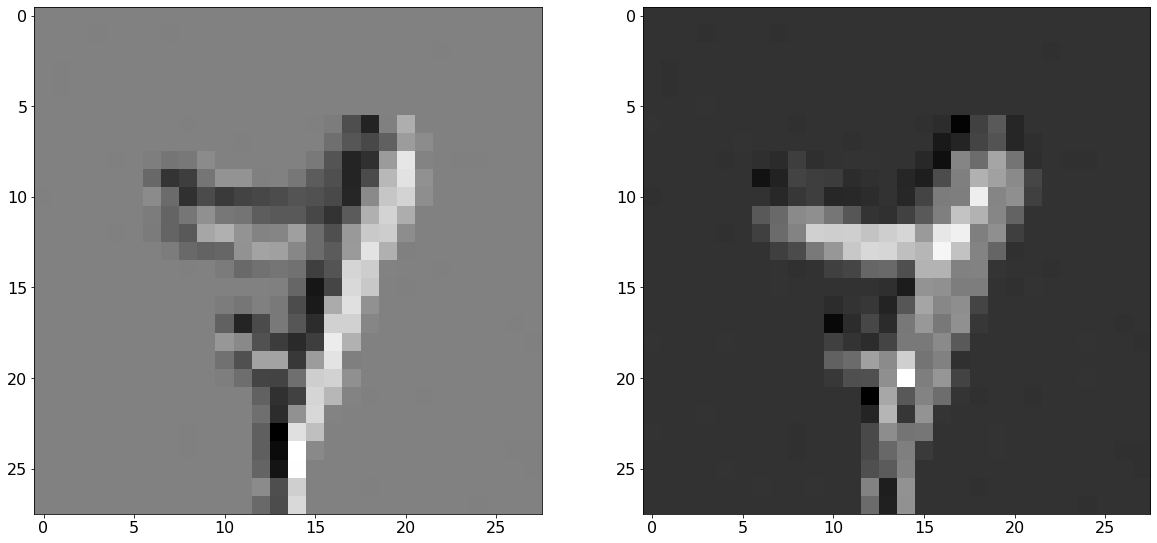

In [209]:
fig, ax = plt.subplots(1,conved.shape[1], figsize=(20,20))
for i in range(conved.shape[1]):
    ax[i].imshow(conved[0][i].to("cpu").detach().numpy(), cmap="gray")

In [5]:
class Layer:
    def __init__(self, num_neurons, num_inputs_per_neuron, device):
        self.w = torch.randn(num_neurons, num_inputs_per_neuron, dtype=torch.float32, requires_grad=True, device=device) 
        self.b = torch.randn(num_neurons, 1, dtype=torch.float32, requires_grad=True, device=device) 
        

    def forward(self, x):
        outer = ((self.w @ x) + self.b)
        # for i in range(outer.shape[-2]):
        #     mean = torch.mean(outer[i, :]).to(device)
        #     sd = torch.sqrt(torch.var(outer[i, :])).to(device)
        #     outer[i, :] = (outer[i, :] - mean) / sd
        out = torch.nn.functional.tanh(outer)
        # print(out.shape)
        return out
    

In [6]:
test_ten = torch.randn(1,2,3,4)
test_ten[:,0,:,:]

tensor([[[-0.6789,  0.4792,  0.6931, -0.6475],
         [ 0.3496,  0.8261, -0.6828, -0.8443],
         [ 1.6337, -0.0258,  1.3919, -0.9389]]])

In [7]:
variance = torch.var(test_ten, dim=-3, keepdim=True)
check = test_ten[:, 0,:,:] / variance
check, variance

(tensor([[[[-6.7825e-01,  3.1319e-01,  1.7143e+01, -6.0761e-01],
           [ 8.7490e+01,  3.7891e-01, -1.4079e+00, -2.3284e+00],
           [ 8.8929e-01, -6.9566e-02,  1.5702e+00, -5.2097e-01]]]]),
 tensor([[[[1.0010, 1.5301, 0.0404, 1.0656],
           [0.0040, 2.1803, 0.4850, 0.3626],
           [1.8371, 0.3708, 0.8865, 1.8023]]]]))

In [8]:
# Conv Layer using calling convolver

# commented out w worked

class Conv_layer():
    def __init__(self, img, filter_size:int, num_features: int, device=device):
        self.device = device
        if(img.dim() <= 2):
            self.img = img.unsqueeze(dim=0)
        else:
            self.img = img
        self.num_features = num_features
        # self.w = torch.randn(num_features * self.img.shape[-3], filter_size, filter_size, requires_grad=True, dtype=torch.float32, device=self.device)
        self.w = torch.randn(num_features, filter_size, filter_size, requires_grad=True, dtype=torch.float32, device=self.device) 
        # self.wel = torch.tensor([[[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], [[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]], dtype=torch.float32, device=device)
        # # print(padded_image.shape, self.wel.shape)
        self.b = torch.randn(1, self.img.shape[-1] * self.img.shape[-2], requires_grad=True, dtype=torch.float32, device=self.device) 
        self.gamma = torch.randn(1, dtype=torch.float32, device = self.device, requires_grad=True)
        self.beta = torch.randn(1, dtype=torch.float32, device = self.device, requires_grad=True)

    def convolve(self, image: torch.tensor):
        # print("kern shape = ", self.w.shape)
        convolver = Convolver(kern=self.w, x=image, bias=self.b)
        conv_img = convolver.convolve()
        return conv_img
    
    def forward_relu(self, image: torch.tensor):
        conv_img = self.convolve(image) 
        #batch_norm
        normalised = self.batch_norm(conv_img)
        conv_img = normalised 
        # conv_img_temp = conv_img.clone() 
        # for i in range(conv_img_temp.shape[-4]):
        #     for j in range(conv_img_temp.shape[-3]):
        #         mean = torch.mean(conv_img_temp[i,j,:,:])
        #         # variance=torch.zeros(1, requires_grad=True)
        #         variance = torch.var(conv_img_temp, dim=-3, keepdim=True)
        #         copy = conv_img_temp[i,j,:,:].clone()
        #         conv_img_temp[i,j,:,:] = (copy - mean) / torch.sqrt(variance)
        out = torch.nn.functional.tanh(conv_img)
        return out
    
    def batch_norm(self, input):
        # conv_img_temp = input.clone()
        # for i in range(conv_img_temp.shape[-3]):
        #     mean = torch.mean(conv_img_temp, dim=-3, keepdim=True)
        #     # variance=torch.zeros(1, requires_grad=True)
        #     variance = torch.var(conv_img_temp, dim=-3, keepdim=True)
        #     normalised = (conv_img_temp[:,i,:,:] - mean) / torch.sqrt(variance + 1e-8)
        #     # print("conv: ", conv_img_temp.shape)
        #     # print("mean: ", mean.shape)
        #     # print("var: ", var.shape)
        #     conv_img_temp[:,i,:,:] = normalised
        conv_img_temp = input.clone()
        
        stack = []
        for j in range(conv_img_temp.shape[-4]):
            # for i in range(conv_img_temp.shape[-3]):  # Iterate over the channel dimension
            mean = torch.mean(conv_img_temp, dim=-3, keepdim=True)
            variance = torch.var(conv_img_temp, dim=-3, keepdim=True, unbiased=True)
            normal = [(conv_img_temp[j][i] - mean) / torch.sqrt(variance + 1e-8) for i in range(conv_img_temp.shape[-3])]
            print(normal[0].shape)
            stack.append(torch.concat(normal, dim=0))
    
        conv_img_temp = torch.stack(stack)

        return conv_img_temp
    


In [9]:
class Pool_Layer:

    def __init__(self, device=device):
        self.device=device
        pass

    def pool(self, step_size: int, conv_img: torch.tensor):
        pool_kern = torch.ones(step_size, step_size, device=self.device)
        pool_size = [batch_size, conv_img.shape[-3], int((conv_img.shape[-2] - step_size)/step_size + 1), int((conv_img.shape[-1] - step_size)/step_size + 1)]
        pool_img = torch.zeros(pool_size, device=device)
        for feat in range(num_features):
            row = 0
            for i in range(pool_img.shape[-2]):
                col = 0
                for j in range(pool_img.shape[-1]):
                    pixels = conv_img[:, feat, row:row + step_size, col:col + step_size]
                    conv = pixels * pool_kern
                    pool_img[:, feat, i, j] = torch.max(conv)
                    col += step_size 
                    
                row += step_size 
        return pool_img

In [10]:
class CNN:
    #num_inputs per neuron=batch_size
    def __init__(self, num_conected_layers, num_conv_layers, num_neurons_per_layer, 
                 num_final_out, datagen, batch_size, device=device):
        
        self.device = device
        self.datagen = datagen(batch_size)
        img, _ = self.datagen.data_generator()
        print(img.shape)
        self.convlayers = [Conv_layer(img, filter_size, num_features)]
        for _ in range(1, num_conv_layers):
            self.convlayers.append(Conv_layer(img, filter_size, num_features))

        self.num_inputs_per_neuron = (img.shape[-1] * img.shape[-2]) * num_features**(num_conv_layers) 
        # print("num_inputs = ", self.num_inputs_per_neuron) 

        self.layers = [Layer(num_neurons_per_layer, self.num_inputs_per_neuron, device=device)]
        for _ in range(1, num_conected_layers-1):
            self.layers.append(Layer(num_neurons_per_layer, num_neurons_per_layer, device=device))
        self.layers.append(Layer(num_final_out, num_neurons_per_layer, device=device))
    
    def forward(self, x):
        c = 0
        out=torch.zeros(1, requires_grad=True)
        for i in range(0, num_conv_layers):
            if i==0:
                out = self.convlayers[0].forward_relu(x)
            elif i==num_conv_layers-1:
                out = self.convlayers[i].convolve(out)
                out = out.reshape(self.num_inputs_per_neuron, batch_size)
            else:
                out = self.convlayers[i].forward_relu(out)

        for i in range(0, num_connected_layers):
            # print("out shape check= ",out.shape)
            out = self.layers[i].forward(out)
        
        return out
    
    def train(self, epochs, learning_rate):

        loss_func = nn.CrossEntropyLoss()
        for i in range(epochs):
            x, y = self.datagen.data_generator()
            out = self.forward(x).view(y.shape[0], y.shape[1])
            # out = torch.tensor([-torch.inf if i.item()==0.0 else i for i in out.flatten()], device=device, requires_grad=True).view(y.shape[0], y.shape[1])
            loss = loss_func(out, y) 
            # loss = ((y - out)**2).flatten().sum() 
            print(f"Loss: {loss} at epoch: {i}")
            loss.backward()

            for conv_layer in self.convlayers:
                # w_grad = torch.tensor([c.item() if torch.abs(c) < 1000.0 else 1000.0 for c in conv_layer.w.grad.flatten()], dtype=torch.float, device=self.device)
                # print(w_grad, "\n", type(conv_layer.w.grad))
                # conv_layer.w.grad = w_grad
                # b_grad = torch.tensor([c.item() if torch.abs(c) < 100.0 else 100.0 for c in conv_layer.b.grad.flatten()], dtype=torch.float, device=self.device)
                # conv_layer.b.grad = b_grad
                conv_layer.w.data -= learning_rate * conv_layer.w.grad
                conv_layer.b.data -= learning_rate * conv_layer.b.grad
                conv_layer.w.grad = None
                conv_layer.b.grad = None
                
            for layer in self.layers:
                layer.w.data -= learning_rate * layer.w.grad
                layer.b.data -= learning_rate * layer.b.grad
                layer.w.grad = None
                layer.b.grad = None

In [19]:
batch_size = 1
emb_dim = 20

In [20]:
class Datagen:
    def __init__(self, batch_size) -> None:
        self.batch_size = batch_size

    def data_generator(self, fix_seed=False, train=True):
        if fix_seed==True:
            seed_idx = torch.tensor(int(input("Enter seed index number")))
        else:
            seed_idx = (torch.randint(low=0, high=len(train_data) - self.batch_size, size=(1,1))).item()
        
        if train:
            y_out = torch.tensor(train_data['label'].iloc[seed_idx:seed_idx+self.batch_size].to_numpy()).to(device)
            x = (torch.tensor(train_data.iloc[seed_idx:seed_idx+self.batch_size, 1:].to_numpy()).view(self.batch_size, 1, 28, 28).to(device))
        else:
            y_out = torch.tensor(test_data['label'].iloc[seed_idx:seed_idx+self.batch_size].to_numpy()).to(device)
            x = (torch.tensor(test_data.iloc[seed_idx:seed_idx+self.batch_size, 1:].to_numpy()).view(batch_size, 1, 28, 28).to(device))
            

        def one_hot_encoder(y):
            y_out = []
            for i in y:
                # num = np.array([-torch.inf for _ in range(num_classifications)])
                num = np.zeros(num_classifications)
                num[i] = 1
                y_out.append(num)
            return(torch.tensor(np.array(y_out), dtype=torch.float32)).to(device)

        embedding = nn.Embedding(num_classifications, emb_dim, device=device)
        # y_out = torch.transpose(embedding(y_out), 0, 1)
        y_out = one_hot_encoder(y_out)
        return x, y_out



In [21]:
datagen = Datagen(batch_size=batch_size)

In [22]:
x, y = datagen.data_generator()
print(x.shape, y[0])

torch.Size([1, 1, 28, 28]) tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='mps:0')


In [23]:
cnn = CNN(num_connected_layers, num_conv_layers, num_neurons_per_layer, num_classifications, Datagen, batch_size, device)

torch.Size([1, 1, 28, 28])


In [24]:
cnn.forward(x=x).view(y.shape[0], y.shape[1])

torch.Size([1, 1, 28, 28])


RuntimeError: shape '[1, 2, 28, 28]' is invalid for input of size 3136

In [170]:
cnn.train(epochs=200, learning_rate=0.003)

Loss: 3.868053913116455 at epoch: 0


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [MPSFloatType [1, 4, 28, 28]], which is output 0 of torch::autograd::CopySlices, is at version 4; expected version 3 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [ ]:
test_ten[:, 0,:,:] / torch.var(test_ten, dim=-3, keepdim=True), test_ten

(tensor([[[[-0.5986,  0.6070],
           [-0.6288,  4.8591],
           [ 0.6652, -0.9033]],
 
          [[ 8.8204, -1.6444],
           [-0.2468, 10.5560],
           [-0.1618, -0.9028]]],
 
 
         [[[-0.0774,  0.5193],
           [-5.6927,  0.8019],
           [ 2.5390, -0.7013]],
 
          [[ 1.1399, -1.4069],
           [-2.2342,  1.7421],
           [-0.6177, -0.7008]]]]),
 tensor([[[[-0.1104,  1.0044],
           [-2.7692,  0.5621],
           [ 1.0932, -0.7909]],
 
          [[-0.0258, -0.3340],
           [-1.1425,  0.4769],
           [-1.4092,  1.0791]],
 
          [[ 0.6723, -1.5676],
           [ 1.3950,  1.1040],
           [-0.6417,  0.2060]]],
 
 
         [[[ 1.6274, -2.7210],
           [-1.0868,  1.2211],
           [-0.2660, -0.7905]],
 
          [[ 1.9373,  0.0235],
           [ 0.2744, -0.1599],
           [ 0.0672,  1.1450]],
 
          [[-0.2697, -1.7399],
           [-0.6700, -0.2894],
           [-1.1986, -0.5805]]]]))

In [28]:
print(cnn.convlayers[1].w)

tensor([[[-0.8211, -0.4645,  0.6627],
         [-0.2683, -0.2269, -0.4489],
         [ 1.6862,  0.5582, -0.9445]],

        [[ 0.4805, -1.4488, -1.0407],
         [-1.7504, -2.1450, -0.4874],
         [-1.4110, -1.5698, -1.9108]],

        [[-0.0635,  1.1047,  0.5695],
         [-1.0960,  1.0888,  2.2447],
         [-0.3512, -0.7286, -0.2892]],

        [[-0.8823, -1.3006,  0.3239],
         [-0.2726, -0.5126, -1.5790],
         [-1.1502, -1.4733, -2.0099]]], device='mps:0', requires_grad=True)


In [ ]:
class Pool_layer:
    def __init__(self, x, device=device):
        self.device = device
        pass

    def pool(self, step_size: int, conv_img: torch.tensor):
        pool_kern = torch.ones(step_size, step_size, device=self.device)
        pool_size = [conv_img.shape[-3], int((conv_img.shape[-2] - step_size)/step_size + 1), int((conv_img.shape[-1] - step_size)/step_size + 1)]
        pool_img = torch.zeros(pool_size, device=device)
        for feat in range(num_features):
            row = 0
            for i in range(pool_img.shape[-2]):
                col = 0
                for j in range(pool_img.shape[-1]):
                    pixels = conv_img[feat, row:row + step_size, col:col + step_size]
                    conv = pixels * pool_kern
                    pool_img[feat, i, j] = torch.max(conv)
                    col += step_size 
                    
                row += step_size 
        return pool_img

In [ ]:
# for multi dimensioanl images, conved img size != img size, reduces size by 2 but increases dims by 2
# convolution using a toeplitz matrix
class Convolver2:
    
    def __init__(self, kernel, x, bias, device=device) -> None:
        self.kern = torch.randn(num_features, filter_size, filter_size, requires_grad=True, dtype=torch.float32, device=device)
        print("Kern = \n", self.kern)
        if(x.dim() <= 2):
            self.img = x.unsqueeze(dim=0)
        else:
            self.img = x

    def find_n(self, i, n):
        if n >= 0 :
            end_pos = self.kern.shape[i] - 1 + ((n-1) * step_size) 
            if end_pos >= (self.img.shape[i] - 1):
                return n
            else:
                return self.find_n(i, n+1)
        else:
            print("Initialise n above or equal to 0") 
            return -9999


    def get_n_flatten_pad(self):
        n = torch.zeros(2)
        for i in range(n.shape[0]):
            n[i] = self.find_n(-i - 1, n[i])
            
        self.bias = torch.randn(int(torch.prod(n)), requires_grad=True, dtype=torch.float32, device=device)
        test_pad_0 = filter_size + (int(n[-1].item()) - 1) * step_size - self.img.shape[-1]
        test_pad_1 = filter_size + (int(n[-2].item()) - 1) * step_size - self.img.shape[-2]
        print(test_pad_0)
        pad_black = nn.functional.pad(self.img, (0, test_pad_0, 0, test_pad_1))
        # pad_black = nn.functional.pad(self.img, (1, 1, 1, 1))
        # n = torch.zeros(2)
        # for i in range(2):
        #     n[i] = ((pad_black.shape[-i - 1] - filter_size) / step_size) + 1
        
        flat_pad_black = pad_black.flatten().clone().detach().view(pad_black.shape[-3], pad_black.shape[-2]*pad_black.shape[-1]).float()

        flat_kern = self.kern.view(num_features, filter_size * filter_size)

        return n, pad_black, flat_pad_black, flat_kern, test_pad_0, test_pad_1
    

    def change_kern_multi(self):
        n, pad_black, flat_pad_black, flat_kern, test_pad_0, test_pad_1 = self.get_n_flatten_pad()

        new_kern = torch.zeros(num_features * self.img.shape[-3], int(torch.prod(n).item()), pad_black.shape[-2] * pad_black.shape[-1], device=device) #produces num_feat x n x n convolution
        print(new_kern.shape)

        flat_kern = torch.cat([flat_kern, flat_kern], dim=0)
        print(flat_kern.shape)
        print("n = ", n)
        print("Pad_ =", pad_black.shape)

        for k  in range(new_kern.shape[-3]):

            num_steps = 0
            start_idx = 0
            for i in range(new_kern.shape[-2]):


                j = 0
                c = 0
                if i == 0:
                    start_idx = start_idx
                elif num_steps % int(n[0].item()) != 0:
                # elif i % int(n[0].item()) != 0:
                    start_idx += step_size
                else: 
                    start_idx += (filter_size - 1) + pad_black.shape[-2]
                    # start_idx = int(i//int(n[0].item()) * pad_black.shape[-2])
                    

                
                # while j < new_kern.shape[-1] and start_idx+j < new_kern.shape[-1]:
                while j < new_kern.shape[-1] and start_idx+j+filter_size <= new_kern.shape[-1]:
                    # print(start_idx + j)
                    new_kern[k][i][start_idx + j:start_idx + j + filter_size] = flat_kern[k][c:c + filter_size]
                    c += filter_size
                    j += pad_black.shape[-2]
                    if c == flat_kern.shape[-1]:
                        break
                
                num_steps += 1
                
        return new_kern, flat_pad_black, n, test_pad_0, test_pad_1
    
    def convolve(self):
    
        start_time = time.time()

        changed_kern, flat_pad_black, n, test_pad_0, test_pad_1 = self.change_kern_multi()
        print("changed_kern = ",changed_kern.shape)

        copy_flat_img = torch.cat([flat_pad_black, flat_pad_black], dim=0)
        print(copy_flat_img.shape)

        conved_mat = changed_kern @ copy_flat_img.unsqueeze(dim=-1) 

        print(conved_mat.shape)

        squeezed_convd_mat = conved_mat.squeeze(dim=-1)
        
        mat_conv_test = torch.zeros(squeezed_convd_mat.shape, device=device)
        print("squeezed_convd_mat shape = ",squeezed_convd_mat.shape)

        # shifting back the shifted pixels because of the padding
        # mat_conv_test[:, :mat_conv_test.shape[-1] - (test_pad_0 + test_pad_1 - 1)] = squeezed_convd_mat[:, (test_pad_0 + test_pad_1 - 1):]
        # mat_conv_test[:, mat_conv_test.shape[-1] - (test_pad_0 + test_pad_1 - 1):] = squeezed_convd_mat[:, 0:(test_pad_0 + test_pad_1 - 1)]

        # conv_img = mat_conv_test.reshape(num_features * self.img.shape[-3], int(n[-2].item()), int(n[-1].item()))
        conv_img = squeezed_convd_mat.reshape(num_features * self.img.shape[-3], int(n[-2].item()), int(n[-1].item()))
        end_time = time.time()
        print(end_time - start_time)
        return conv_img, n, changed_kern #returns convolved image 
